In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

In [3]:
trainset = datasets.MNIST('./datasets/', download=True, train=True, transform=transform)
valset = datasets.MNIST('./datasets', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

Move everything to GPU

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1])


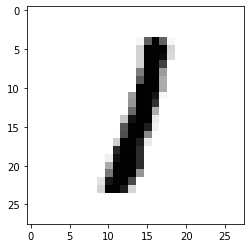

In [32]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [33]:
input_size = 784
hidden_sizes = [16, 16]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Sigmoid(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Sigmoid(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Sigmoid())

model.cuda()
print(model)


Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=16, out_features=10, bias=True)
  (5): Sigmoid()
)


In [71]:
def calc_acc():
    correct_count, all_count = 0, 0
    for images, labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784).cuda()
            with torch.no_grad():
                logps = model(img)

            output_labels = logps.flatten().tolist()
            pred_label = output_labels.index(max(output_labels))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))


In [72]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.0)
time0 = time()
epochs = 2
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1).cuda()

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        labels = nn.functional.one_hot(labels, num_classes=10).float().cuda()
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e,
              running_loss/len(trainloader)))
        calc_acc()

print("\nTraining Time (in minutes) =", (time()-time0)/60)


Epoch 0 - Training loss: 0.012088260649622026
Number Of Images Tested = 10000

Model Accuracy = 0.9249
Epoch 1 - Training loss: 0.012035591099763722
Number Of Images Tested = 10000

Model Accuracy = 0.9248

Training Time (in minutes) = 0.6479721347490947


In [73]:
torch.save(model, './models/000b.pt')